In [1]:
# Pandas and NumPy are very useful Python library for data manipulation, cleaning, and analysis.
import pandas as pd
import numpy as np
# Here, I have disabled a false alarm that would otherwise trip later in the project.
pd.options.mode.chained_assignment = None

# The datetime library will let me filter the data by reporting date.
from datetime import datetime, timedelta

# Requests and urlopen will also allow me to access the NVD data from the NIST web site.
import requests
from urllib.request import urlopen

# Using zipfile and BytesIO is how I will decompress and access the actual NVD data.
from io import BytesIO
from zipfile import ZipFile

# Since the NVD data is housed in JavaScript Object Notation (JSON) format, I will need the json_normalize function to access and manipulate the information.
from pandas.io.json import json_normalize

In [2]:
# Expanding view area to facilitate data manipulation.
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 100)

In [3]:
# I will later use the below date in order to filter the data so that it only contains vulnerabilities reported before a specific cyber event.
cutoff_date = pd.to_datetime('2017-03-12')
# The below specifies how many days before the incident the model should stop incorporating NVD events.
time_interval = 365
start_date = cutoff_date - timedelta(days=time_interval)

# I am using a cutoff date of March 12, 2017 because, although US-CERT released its alert regarding the vulnerability used in the Equifax Hack on March 8, the entry in the NVD did not appear until March 11.

# The below years signify which years of NVD data I will use.
years = [2016, 2017]

In [4]:
# Accessing and unzipping the data, and storing it in a pandas data frame.
counter = 0
df = []

for year in years:
    url = 'https://nvd.nist.gov/feeds/json/cve/1.0/nvdcve-1.0-'+str(year)+'.json.zip'
    extract_target = 'nvdcve-1.0-'+str(year)+'.json'
    # Extracting zip file
    z = urlopen(url)
    stage_1 = z.read()
    stage_2 = (BytesIO(stage_1))
    stage_3 = ZipFile(stage_2)
    stage_4 = stage_3.extract(extract_target)
    yearly_data = pd.read_json(stage_4)
    if counter == 0:
        df = yearly_data
    else:
        df = df.append(yearly_data)
    counter +=1
    print(year)
    print('complete')

2016
complete
2017
complete


In [5]:
# Flatenning CVE_Items
CVE_Items = json_normalize(df["CVE_Items"])

In [6]:
# Concatenating and cleaning up the data frame by dropping the original index as well as the nested JSON column
df = pd.concat([df.reset_index(), CVE_Items], axis=1)
df = df.drop(["index", "CVE_Items"], axis=1)

In [7]:
len(df["cve.CVE_data_meta.ID"].unique())

25549

In [8]:
df = df.rename(columns={"cve.CVE_data_meta.ID": "CVE ID"})
CVE_ID = df["CVE ID"]
df.drop(labels=["CVE ID"], axis=1,inplace = True)
df.insert(0, "CVE ID", CVE_ID)

In [9]:
len(df[df.isnull().any(axis=1)])

21321

In [10]:
len(df[df["impact.baseMetricV2.acInsufInfo"].isnull()])

21208

In [11]:
df = df.drop(["impact.baseMetricV2.acInsufInfo"], axis=1)

In [12]:
len(df[df.isnull().any(axis=1)])

3674

In [13]:
df[df.isnull().any(axis=1)].head()

,CVE ID,CVE_data_type,CVE_data_format,CVE_data_version,CVE_data_numberOfCVEs,CVE_data_timestamp,configurations.CVE_data_version,configurations.nodes,cve.CVE_data_meta.ASSIGNER,cve.affects.vendor.vendor_data,cve.data_format,cve.data_type,cve.data_version,cve.description.description_data,cve.problemtype.problemtype_data,cve.references.reference_data,impact.baseMetricV2.cvssV2.accessComplexity,impact.baseMetricV2.cvssV2.accessVector,impact.baseMetricV2.cvssV2.authentication,impact.baseMetricV2.cvssV2.availabilityImpact,impact.baseMetricV2.cvssV2.baseScore,impact.baseMetricV2.cvssV2.confidentialityImpact,impact.baseMetricV2.cvssV2.integrityImpact,impact.baseMetricV2.cvssV2.vectorString,impact.baseMetricV2.cvssV2.version,impact.baseMetricV2.exploitabilityScore,impact.baseMetricV2.impactScore,impact.baseMetricV2.obtainAllPrivilege,impact.baseMetricV2.obtainOtherPrivilege,impact.baseMetricV2.obtainUserPrivilege,impact.baseMetricV2.severity,impact.baseMetricV2.userInteractionRequired,impact.baseMetricV3.cvssV3.attackComplexity,impact.baseMetricV3.cvssV3.attackVector,impact.baseMetricV3.cvssV3.availabilityImpact,impact.baseMetricV3.cvssV3.baseScore,impact.baseMetricV3.cvssV3.baseSeverity,impact.baseMetricV3.cvssV3.confidentialityImpact,impact.baseMetricV3.cvssV3.integrityImpact,impact.baseMetricV3.cvssV3.privilegesRequired,impact.baseMetricV3.cvssV3.scope,impact.baseMetricV3.cvssV3.userInteraction,impact.baseMetricV3.cvssV3.vectorString,impact.baseMetricV3.cvssV3.version,impact.baseMetricV3.exploitabilityScore,impact.baseMetricV3.impactScore,lastModifiedDate,publishedDate
0,CVE-2016-0001,CVE,MITRE,4,9927,2019-07-19T07:54Z,4.0,[],cve@mitre.org,[],MITRE,CVE,4.0,"[{'lang': 'en', 'value': '** REJECT ** DO NOT...",[{'description': []}],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-05-11T14:29Z,2017-05-11T14:29Z
3,CVE-2016-0004,CVE,MITRE,4,9927,2019-07-19T07:54Z,4.0,[],cve@mitre.org,[],MITRE,CVE,4.0,"[{'lang': 'en', 'value': '** REJECT ** DO NOT...",[{'description': []}],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-05-11T14:29Z,2017-05-11T14:29Z
12,CVE-2016-0013,CVE,MITRE,4,9927,2019-07-19T07:54Z,4.0,[],cve@mitre.org,[],MITRE,CVE,4.0,"[{'lang': 'en', 'value': '** REJECT ** DO NOT...",[{'description': []}],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-05-11T14:29Z,2017-05-11T14:29Z
16,CVE-2016-0017,CVE,MITRE,4,9927,2019-07-19T07:54Z,4.0,[],cve@mitre.org,[],MITRE,CVE,4.0,"[{'lang': 'en', 'value': '** REJECT ** DO NOT...",[{'description': []}],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-05-11T14:29Z,2017-05-11T14:29Z
18,CVE-2016-0019,CVE,MITRE,4,9927,2019-07-19T07:54Z,4.0,"[{'operator': 'OR', 'cpe_match': [{'vulnerable...",cve@mitre.org,"[{'vendor_name': 'microsoft', 'product': {'pro...",MITRE,CVE,4.0,"[{'lang': 'en', 'value': 'The Remote Desktop P...","[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'http://www.securitytracker.com/id/10...,MEDIUM,NETWORK,NONE,COMPLETE,9.3,COMPLETE,COMPLETE,AV:N/AC:M/Au:N/C:C/I:C/A:C,2.0,8.6,10.0,False,False,False,HIGH,NaN,HIGH,NETWORK,HIGH,8.1,HIGH,HIGH,HIGH,NONE,UNCHANGED,NONE,CVSS:3.0/AV:N/AC:H/PR:N/UI:N/S:U/C:H/I:H/A:H,3.0,2.2,5.9,2018-10-30T16:27Z,2016-01-13T05:59Z


In [14]:
df[df.isnull().any(axis=1)].iloc[0]["cve.description.description_data"]

[{'lang': 'en',
  'value': '** REJECT **  DO NOT USE THIS CANDIDATE NUMBER. ConsultIDs: none. Reason: The CNA or individual who requested this candidate did not associate it with any vulnerability during 2016. Notes: none.'}]

In [15]:
y = 0
for x in df["cve.description.description_data"]:
#    print((json_normalize(x)["value"])[0])
    if "REJECT" in (json_normalize(x)["value"])[0]:
        y+=1
    else:
        y
print(y)

2955


In [16]:
df = df.dropna(axis=0)

In [17]:
# Converting the data to pandas date-time format
df["publishedDate"] = pd.to_datetime(df["publishedDate"])

In [18]:
df = df[(df["publishedDate"] < cutoff_date) & (df["publishedDate"] > start_date)]

In [19]:
df["cve.problemtype.problemtype_data"].head(1).values[0]

[{'description': [{'lang': 'en', 'value': 'CWE-20'}]}]

In [20]:
# Extracting the CWE codes from "cve.problemtype.problemtype_data"
# Creating empty list for 1st CWE code
CWE_entry_1 = []
# Isolating index so that all values align properly
CWE_index = df["cve.problemtype.problemtype_data"].index

# Running a "for" loop in order to extract and normalize the information contained with the JSON structure.
for x in df["cve.problemtype.problemtype_data"]:
    CWE_normalized_json_step_1 = json_normalize(x)
    CWE_normalized_json_step_2 = CWE_normalized_json_step_1["description"][0]
    raw_CWE_entry = json_normalize(CWE_normalized_json_step_2)["value"][0]
    clean_CWE_entry = str(raw_CWE_entry)
    # Adding 1st CWE code
    CWE_entry_1.append(clean_CWE_entry)
    
CWE_entry_1 = pd.Series(CWE_entry_1, index = CWE_index)

In [21]:
# Creating empty list for 2nd CWE code
CWE_entry_2 = []

for x in df["cve.problemtype.problemtype_data"]:
    try:
        CWE_normalized_json_step_1 = json_normalize(x)
        CWE_normalized_json_step_2 = CWE_normalized_json_step_1["description"][0]
        raw_CWE_entry = json_normalize(CWE_normalized_json_step_2)["value"][1]
        clean_CWE_entry = str(raw_CWE_entry)
        CWE_entry_2.append(clean_CWE_entry)
        # adding 2nd CWE code
    
    except:
        CWE_entry_2.append("NONE")
        # creating a "NONE" label if secondary CWE code is not available

CWE_entry_2 = pd.Series(CWE_entry_2, index = CWE_index)

In [22]:
# Merging two series of CWE codes
df_CWE = pd.concat([CWE_entry_1, CWE_entry_2], axis=1)
# Renaming the columns
df_CWE.columns = ["CWE Code 1", "CWE Code 2"]

In [23]:
# Identifying all the unique primary CWE codes
CWE_entry_1.unique()

array(['CWE-20', 'CWE-119', 'CWE-200', 'CWE-254', 'CWE-264', 'CWE-19',
       'CWE-284', 'NVD-CWE-Other', 'CWE-601', 'CWE-79', 'CWE-89',
       'CWE-77', 'CWE-399', 'CWE-611', 'CWE-532', 'NVD-CWE-noinfo',
       'CWE-78', 'CWE-255', 'CWE-502', 'CWE-352', 'CWE-275', 'CWE-693',
       'CWE-189', 'CWE-287', 'CWE-310', 'CWE-285', 'CWE-327', 'CWE-362',
       'CWE-94', 'CWE-295', 'CWE-22', 'CWE-426', 'CWE-320', 'CWE-476',
       'CWE-125', 'CWE-388', 'CWE-17', 'CWE-416', 'CWE-326', 'CWE-798',
       'CWE-74', 'CWE-190', 'CWE-338', 'CWE-384', 'CWE-59', 'CWE-297',
       'CWE-361', 'CWE-400', 'CWE-191', 'CWE-306', 'CWE-787', 'CWE-345',
       'CWE-640', 'CWE-116', 'CWE-434', 'CWE-91', 'CWE-358', 'CWE-415',
       'CWE-369', 'CWE-172', 'CWE-918', 'CWE-427', 'CWE-704', 'CWE-113',
       'CWE-669', 'CWE-330', 'CWE-93', 'CWE-199', 'CWE-428', 'CWE-184',
       'CWE-18', 'CWE-682', 'CWE-346', 'CWE-129', 'CWE-775', 'CWE-332',
       'CWE-90', 'CWE-417', 'CWE-485', 'CWE-99', 'CWE-134', 'CWE-118',
   

In [24]:
# Identifying all the unique secondary CWE codes
CWE_entry_2.unique()

array(['NONE', 'CWE-284', 'CWE-254', 'CWE-200', 'CWE-310', 'CWE-89',
       'CWE-77', 'CWE-287', 'CWE-190', 'CWE-326', 'CWE-416', 'CWE-362',
       'CWE-22', 'CWE-264', 'CWE-399', 'NVD-CWE-Other', 'CWE-787',
       'CWE-20', 'CWE-189', 'CWE-255', 'CWE-79', 'CWE-78', 'CWE-345',
       'CWE-798', 'CWE-611', 'CWE-476', 'CWE-93', 'CWE-125', 'CWE-285',
       'NVD-CWE-noinfo', 'CWE-74', 'CWE-320', 'CWE-749', 'CWE-59',
       'CWE-191', 'CWE-94', 'CWE-388', 'CWE-415', 'CWE-502', 'CWE-346'],
      dtype=object)

In [25]:
# Defining a function which I will use below
def consolidate_unknowns(x):
    if x == "NVD-CWE-Other" or x == "NVD-CWE-noinfo":
        return "UNKNOWN"
    else:
        return x

In [26]:
df_CWE = df_CWE.applymap(consolidate_unknowns)
CWE_entry_1 = CWE_entry_1.apply(consolidate_unknowns)
CWE_entry_2 = CWE_entry_2.apply(consolidate_unknowns)

In [27]:
# Merging CWE codes onto a master data frame
df_w_CWE_codes = df.join(df_CWE)

In [28]:
df_w_CWE_codes.head()

,CVE ID,CVE_data_type,CVE_data_format,CVE_data_version,CVE_data_numberOfCVEs,CVE_data_timestamp,configurations.CVE_data_version,configurations.nodes,cve.CVE_data_meta.ASSIGNER,cve.affects.vendor.vendor_data,cve.data_format,cve.data_type,cve.data_version,cve.description.description_data,cve.problemtype.problemtype_data,cve.references.reference_data,impact.baseMetricV2.cvssV2.accessComplexity,impact.baseMetricV2.cvssV2.accessVector,impact.baseMetricV2.cvssV2.authentication,impact.baseMetricV2.cvssV2.availabilityImpact,impact.baseMetricV2.cvssV2.baseScore,impact.baseMetricV2.cvssV2.confidentialityImpact,impact.baseMetricV2.cvssV2.integrityImpact,impact.baseMetricV2.cvssV2.vectorString,impact.baseMetricV2.cvssV2.version,impact.baseMetricV2.exploitabilityScore,impact.baseMetricV2.impactScore,impact.baseMetricV2.obtainAllPrivilege,impact.baseMetricV2.obtainOtherPrivilege,impact.baseMetricV2.obtainUserPrivilege,impact.baseMetricV2.severity,impact.baseMetricV2.userInteractionRequired,impact.baseMetricV3.cvssV3.attackComplexity,impact.baseMetricV3.cvssV3.attackVector,impact.baseMetricV3.cvssV3.availabilityImpact,impact.baseMetricV3.cvssV3.baseScore,impact.baseMetricV3.cvssV3.baseSeverity,impact.baseMetricV3.cvssV3.confidentialityImpact,impact.baseMetricV3.cvssV3.integrityImpact,impact.baseMetricV3.cvssV3.privilegesRequired,impact.baseMetricV3.cvssV3.scope,impact.baseMetricV3.cvssV3.userInteraction,impact.baseMetricV3.cvssV3.vectorString,impact.baseMetricV3.cvssV3.version,impact.baseMetricV3.exploitabilityScore,impact.baseMetricV3.impactScore,lastModifiedDate,publishedDate,CWE Code 1,CWE Code 2
24,CVE-2016-0025,CVE,MITRE,4,9927,2019-07-19T07:54Z,4.0,"[{'operator': 'OR', 'cpe_match': [{'vulnerable...",cve@mitre.org,"[{'vendor_name': 'microsoft', 'product': {'pro...",MITRE,CVE,4.0,"[{'lang': 'en', 'value': 'Microsoft Word 2007 ...","[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'http://www.securitytracker.com/id/10...,MEDIUM,NETWORK,NONE,COMPLETE,9.3,COMPLETE,COMPLETE,AV:N/AC:M/Au:N/C:C/I:C/A:C,2.0,8.6,10.0,False,False,False,HIGH,True,LOW,LOCAL,HIGH,7.3,HIGH,HIGH,HIGH,LOW,UNCHANGED,REQUIRED,CVSS:3.0/AV:L/AC:L/PR:L/UI:R/S:U/C:H/I:H/A:H,3.0,1.3,5.9,2018-10-12T22:10Z,2016-06-16 01:59:00,CWE-20,NONE
25,CVE-2016-0026,CVE,MITRE,4,9927,2019-07-19T07:54Z,4.0,"[{'operator': 'OR', 'cpe_match': [{'vulnerable...",cve@mitre.org,"[{'vendor_name': 'microsoft', 'product': {'pro...",MITRE,CVE,4.0,"[{'lang': 'en', 'value': 'The Common Log File ...","[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'http://www.securityfocus.com/bid/939...,MEDIUM,NETWORK,NONE,COMPLETE,9.3,COMPLETE,COMPLETE,AV:N/AC:M/Au:N/C:C/I:C/A:C,2.0,8.6,10.0,False,False,False,HIGH,True,LOW,LOCAL,HIGH,7.8,HIGH,HIGH,HIGH,NONE,UNCHANGED,REQUIRED,CVSS:3.0/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,3.0,1.8,5.9,2018-10-12T22:10Z,2016-11-10 06:59:00,CWE-119,NONE
27,CVE-2016-0028,CVE,MITRE,4,9927,2019-07-19T07:54Z,4.0,"[{'operator': 'AND', 'children': [{'operator':...",cve@mitre.org,"[{'vendor_name': 'microsoft', 'product': {'pro...",MITRE,CVE,4.0,"[{'lang': 'en', 'value': 'Outlook Web Access (...","[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'http://www.securitytracker.com/id/10...,MEDIUM,NETWORK,NONE,NONE,4.3,PARTIAL,NONE,AV:N/AC:M/Au:N/C:P/I:N/A:N,2.0,8.6,2.9,False,False,False,MEDIUM,True,LOW,LOCAL,NONE,5.5,MEDIUM,HIGH,NONE,NONE,UNCHANGED,REQUIRED,CVSS:3.0/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:N/A:N,3.0,1.8,3.6,2018-10-12T22:10Z,2016-06-16 01:59:00,CWE-200,NONE
69,CVE-2016-0070,CVE,MITRE,4,9927,2019-07-19T07:54Z,4.0,"[{'operator': 'OR', 'cpe_match': [{'vulnerable...",cve@mitre.org,"[{'vendor_name': 'microsoft', 'product': {'pro...",MITRE,CVE,4.0,"[{'lang': 'en', 'value': 'The kernel in Micros...","[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'http://www.securityfocus.com/bid/933...,MEDIUM,NETWORK,NONE,NONE,4.3,PARTIAL,NONE,AV:N/AC:M/Au:N/C:P/I:N/A:N,2.0,8.6,2.9,False,False,False,MEDIUM,True,LOW,LOCAL,NONE,5.5,MEDIUM,HIGH,NONE,NONE,UNCHANGED,REQUIRED,CV

In [29]:
# Importing BeautifulSoup and an xml parser to scrape the CWE definitions from the NVD web site
from bs4 import BeautifulSoup
import lxml.etree

In [30]:
# loading the NVD CWE Definitions page and scraping it for the first table that appears
NVD_CWE_description_url = requests.get("https://nvd.nist.gov/vuln/categories")
CWE_definitions_page_soup =  BeautifulSoup(NVD_CWE_description_url.content, "html5lib")
table = CWE_definitions_page_soup.find_all('table')[0] 
df_CWE_definitions = pd.read_html(str(table))[0]

In [31]:
df_CWE_definitions

,Name,CWE-ID,Description
0,CWE-824,Access of Uninitialized Pointer,The program accesses or uses a pointer that ha...
1,CWE-407,Algorithmic Complexity,An algorithm in a product has an inefficient w...
2,CWE-774,Allocation of File Descriptors or Handles With...,The software allocates file descriptors or han...
3,CWE-88,Argument Injection or Modification,The software does not sufficiently delimit the...
4,CWE-405,Asymmetric Resource Consumption (Amplification),Software that does not appropriately monitor o...
5,CWE-287,Authentication Issues,"When an actor claims to have a given identity,..."
6,CWE-119,Buffer Errors,The software performs operations on a memory b...
7,CWE-417,Channel and Path Errors,Weaknesses in this category are related to imp...
8,CWE-171,"Cleansing, Canonicalization, and Comparison Er...",Weaknesses in this category are related to imp...
9,CWE-17,Code,Weaknesses in this category are typically intr...


In [32]:
# Adding the names and definitions for primary CWE codes
df_w_CWE_defs = df_w_CWE_codes.merge(df_CWE_definitions, how="left", left_on= "CWE Code 1", right_on = "Name")

In [33]:
# Renaming columns so they are more descriptive for 1st CWE Code, and dropping "Name" column since it is redundant
df_w_CWE_defs = df_w_CWE_defs.rename(columns={'CWE-ID': 'CWE Code 1 Name', 'Description': 'CWE Code 1 Description'})
df_w_CWE_defs = df_w_CWE_defs.drop(["Name"], axis=1)

In [34]:
# Adding the names and definitions for secondary CWE codes
df_w_CWE_defs = df_w_CWE_defs.merge(df_CWE_definitions, how="left", left_on= "CWE Code 2", right_on = "Name")

In [35]:
# Repeating the process for the second CWE code
df_w_CWE_defs = df_w_CWE_defs.rename(columns={'CWE-ID': 'CWE Code 2 Name', 'Description': 'CWE Code 2 Description'})
df_w_CWE_defs = df_w_CWE_defs.drop(["Name"], axis=1)

In [36]:
df_w_CWE_defs_cleaned = df_w_CWE_defs.drop(["CVE_data_type", "CVE_data_format", "cve.affects.vendor.vendor_data", "cve.problemtype.problemtype_data", "cve.description.description_data", "cve.references.reference_data", "CVE_data_version", "CVE_data_numberOfCVEs", "impact.baseMetricV2.cvssV2.vectorString", "impact.baseMetricV3.cvssV3.vectorString", "CVE_data_timestamp", "configurations.CVE_data_version", "configurations.nodes", "cve.CVE_data_meta.ASSIGNER", "cve.data_format", "cve.data_type", "cve.data_version", "lastModifiedDate", "publishedDate"], axis=1)

In [37]:
df_w_CWE_defs_cleaned.head()

,CVE ID,impact.baseMetricV2.cvssV2.accessComplexity,impact.baseMetricV2.cvssV2.accessVector,impact.baseMetricV2.cvssV2.authentication,impact.baseMetricV2.cvssV2.availabilityImpact,impact.baseMetricV2.cvssV2.baseScore,impact.baseMetricV2.cvssV2.confidentialityImpact,impact.baseMetricV2.cvssV2.integrityImpact,impact.baseMetricV2.cvssV2.version,impact.baseMetricV2.exploitabilityScore,impact.baseMetricV2.impactScore,impact.baseMetricV2.obtainAllPrivilege,impact.baseMetricV2.obtainOtherPrivilege,impact.baseMetricV2.obtainUserPrivilege,impact.baseMetricV2.severity,impact.baseMetricV2.userInteractionRequired,impact.baseMetricV3.cvssV3.attackComplexity,impact.baseMetricV3.cvssV3.attackVector,impact.baseMetricV3.cvssV3.availabilityImpact,impact.baseMetricV3.cvssV3.baseScore,impact.baseMetricV3.cvssV3.baseSeverity,impact.baseMetricV3.cvssV3.confidentialityImpact,impact.baseMetricV3.cvssV3.integrityImpact,impact.baseMetricV3.cvssV3.privilegesRequired,impact.baseMetricV3.cvssV3.scope,impact.baseMetricV3.cvssV3.userInteraction,impact.baseMetricV3.cvssV3.version,impact.baseMetricV3.exploitabilityScore,impact.baseMetricV3.impactScore,CWE Code 1,CWE Code 2,CWE Code 1 Name,CWE Code 1 Description,CWE Code 2 Name,CWE Code 2 Description
0,CVE-2016-0025,MEDIUM,NETWORK,NONE,COMPLETE,9.3,COMPLETE,COMPLETE,2.0,8.6,10.0,False,False,False,HIGH,True,LOW,LOCAL,HIGH,7.3,HIGH,HIGH,HIGH,LOW,UNCHANGED,REQUIRED,3.0,1.3,5.9,CWE-20,NONE,Input Validation,The product does not validate or incorrectly v...,NaN,NaN
1,CVE-2016-0026,MEDIUM,NETWORK,NONE,COMPLETE,9.3,COMPLETE,COMPLETE,2.0,8.6,10.0,False,False,False,HIGH,True,LOW,LOCAL,HIGH,7.8,HIGH,HIGH,HIGH,NONE,UNCHANGED,REQUIRED,3.0,1.8,5.9,CWE-119,NONE,Buffer Errors,The software performs operations on a memory b...,NaN,NaN
2,CVE-2016-0028,MEDIUM,NETWORK,NONE,NONE,4.3,PARTIAL,NONE,2.0,8.6,2.9,False,False,False,MEDIUM,True,LOW,LOCAL,NONE,5.5,MEDIUM,HIGH,NONE,NONE,UNCHANGED,REQUIRED,3.0,1.8,3.6,CWE-200,NONE,Information Leak / Disclosure,An information exposure is the intentional or ...,NaN,NaN
3,CVE-2016-0070,MEDIUM,NETWORK,NONE,NONE,4.3,PARTIAL,NONE,2.0,8.6,2.9,False,False,False,MEDIUM,True,LOW,LOCAL,NONE,5.5,MEDIUM,HIGH,NONE,NONE,UNCHANGED,REQUIRED,3.0,1.8,3.6,CWE-200,NONE,Information Leak / Disclosure,An information exposure is the intentional or ...,NaN,NaN
4,CVE-2016-0073,LOW,LOCAL,NONE,NONE,2.1,PARTIAL,NONE,2.0,3.9,2.9,False,False,False,LOW,False,LOW,LOCAL,NONE,5.0,MEDIUM,HIGH,NONE,LOW,UNCHANGED,REQUIRED,3.0,1.3,3.6,CWE-200,NONE,Information Leak / Disclosure,An information exposure is the intentional or ...,NaN,NaN


In [38]:
import matplotlib.pyplot as plt
# matplotlib is another library for Python that is very powerful when creating data-rich graphics
plt.rcParams.update({'font.size': 16})
# Setting default font size
%matplotlib inline
# Ensuring the all my plots are inline and thus look better

In [39]:
CWE_counts_1 = CWE_entry_1.value_counts().sort_values(axis=0, ascending=False)
CWE_counts_1

CWE-119    1210
CWE-200     761
UNKNOWN     712
CWE-264     628
CWE-284     622
CWE-79      568
CWE-20      503
CWE-399     182
CWE-125     181
CWE-254     167
           ... 
CWE-358       1
CWE-693       1
CWE-669       1
CWE-134       1
CWE-338       1
CWE-332       1
CWE-297       1
CWE-99        1
CWE-485       1
CWE-18        1
Length: 82, dtype: int64

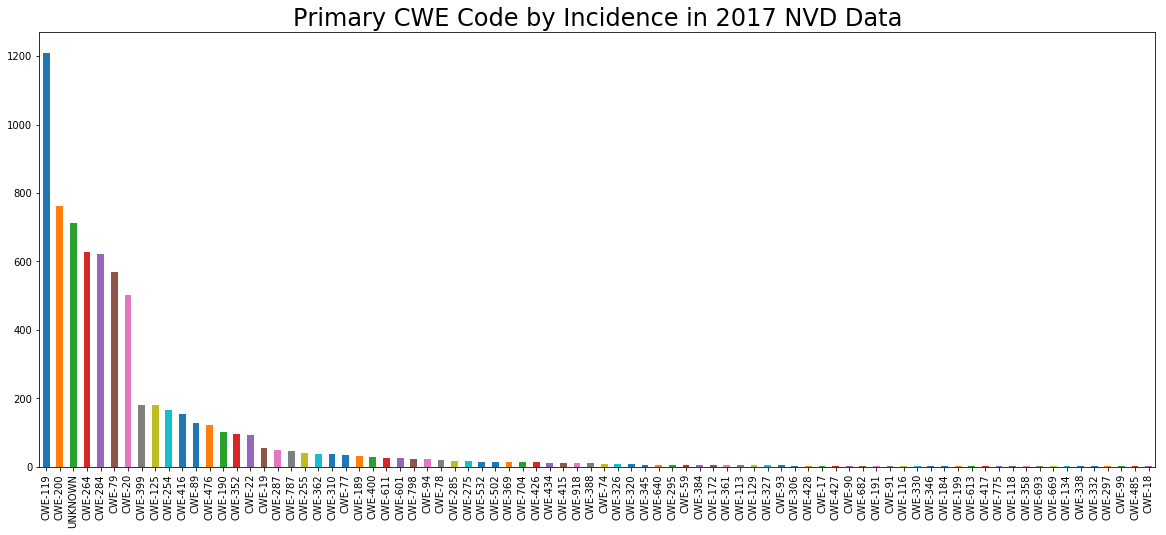

In [40]:
CWE_counts_1.plot(kind = "bar", figsize = (20,8))
plt.title("Primary CWE Code by Incidence in 2017 NVD Data", fontsize = 24)
plt.show();

In [41]:
CWE_119_info = df_w_CWE_defs_cleaned[df_w_CWE_defs_cleaned["CWE Code 1"]=="CWE-119"][["CWE Code 1", "CWE Code 1 Name", "CWE Code 1 Description"]].iloc[0]
print(CWE_119_info[0])
print(CWE_119_info[1])
print(CWE_119_info[2])

CWE-119
Buffer Errors
The software performs operations on a memory buffer, but it can read from or write to a memory location that is outside of the intended boundary of the buffer.


In [42]:
CWE_counts_2 = CWE_entry_2.value_counts().sort_values(axis=0, ascending=False)
CWE_counts_2

NONE       6700
CWE-284      33
CWE-264      23
CWE-787      18
CWE-200      17
CWE-254      17
CWE-310      14
CWE-399      14
UNKNOWN      12
CWE-346      11
           ... 
CWE-93        1
CWE-320       1
CWE-345       1
CWE-749       1
CWE-798       1
CWE-74        1
CWE-191       1
CWE-285       1
CWE-502       1
CWE-94        1
Length: 39, dtype: int64

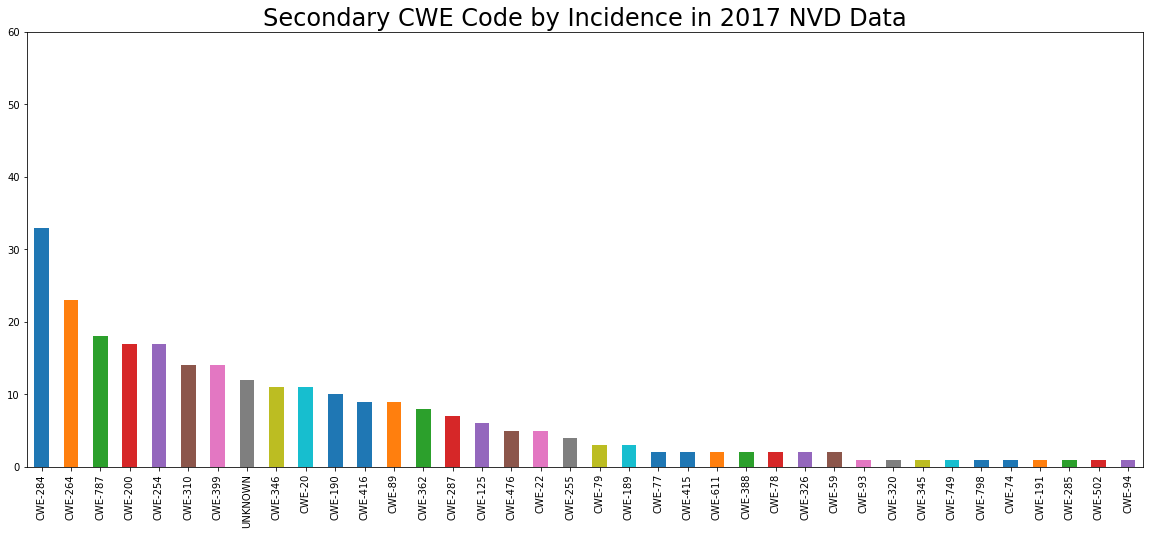

In [43]:
CWE_counts_2.drop("NONE").plot(kind = "bar", figsize = (20,8))
# I have dropped all CWE codes with the label "NONE," because they do not factor into my analysis, and in fact, most NVD entries do not have a secondary CWE code
plt.title("Secondary CWE Code by Incidence in 2017 NVD Data", fontsize = 24)
plt.ylim(top=60)
plt.show();

In [44]:
CWE_200_info = df_w_CWE_defs_cleaned[df_w_CWE_defs_cleaned["CWE Code 1"]=="CWE-200"][["CWE Code 1", "CWE Code 1 Name", "CWE Code 1 Description"]].iloc[0]
print(CWE_200_info[0])
print(CWE_200_info[1])
print(CWE_200_info[2])

CWE-200
Information Leak / Disclosure
An information exposure is the intentional or unintentional disclosure of information to an actor that is not explicitly authorized to have access to that information.


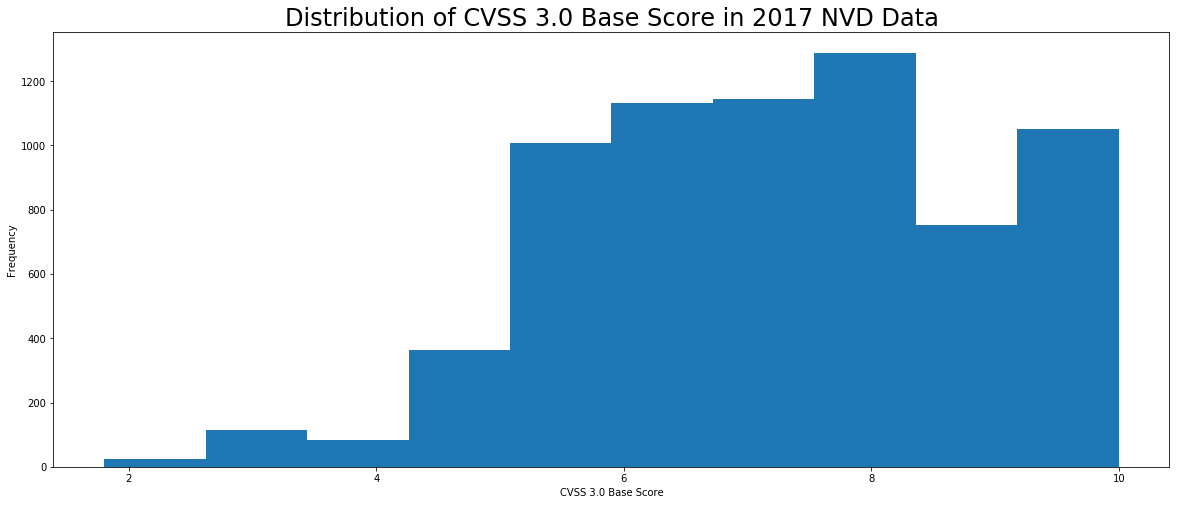

In [45]:
df_w_CWE_defs_cleaned["impact.baseMetricV3.cvssV3.baseScore"].plot(kind = "hist", figsize = (20,8))
plt.title("Distribution of CVSS 3.0 Base Score in 2017 NVD Data", fontsize = 24)
plt.xlabel('CVSS 3.0 Base Score');

In [46]:
# Creating a variable to count primary CWE codes.
CWE_1_count = df_w_CWE_defs_cleaned.groupby(["CWE Code 1"]).count()["CVE ID"].sort_values(ascending=False)

In [47]:
# Extracting the mean base CVSS 3.0 score for each CWE code.
CWE_1_base = df_w_CWE_defs_cleaned.groupby(["CWE Code 1"]).mean()["impact.baseMetricV3.cvssV3.baseScore"].sort_values(ascending=False)

In [48]:
# Concatenating the two series together for use in graphic below
CWE_1_summary = pd.concat([CWE_1_count, CWE_1_base], axis=1, sort=True)

In [49]:
# Renaming columns to allow for easier analysis.
CWE_1_summary = CWE_1_summary.rename(columns={'CVE ID': 'Count', 'impact.baseMetricV3.cvssV3.baseScore': 'CVSS 3.0 Score'})

In [50]:
# Sorting by frequncy of CWE appearance
CWE_1_summary = CWE_1_summary.sort_values(by=['Count'], ascending=False)

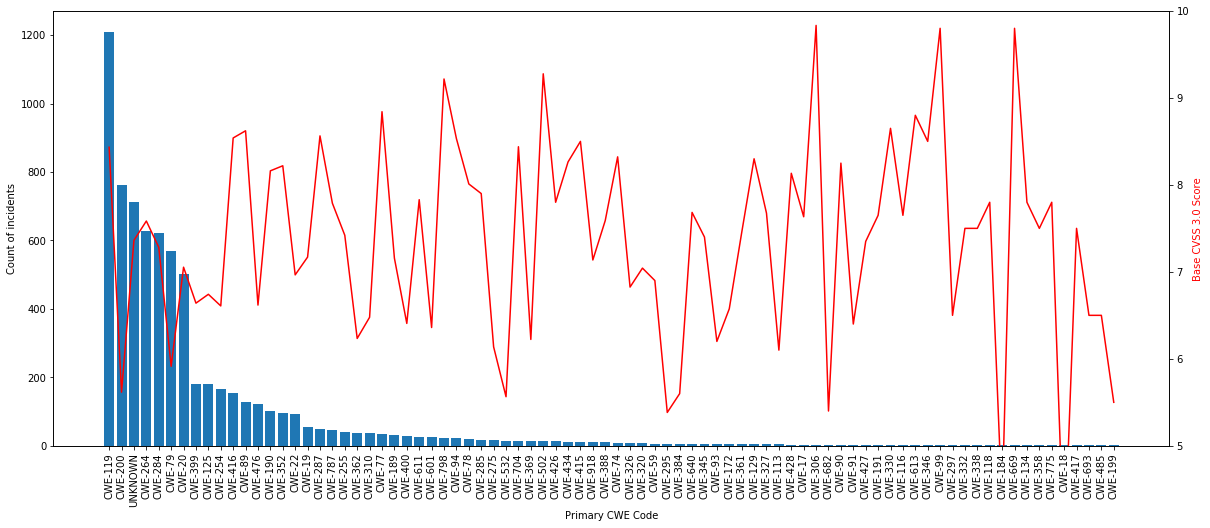

In [51]:
fig, ax1 = plt.subplots(figsize = (20,8))

ax2 = ax1.twinx()
ax1.bar(CWE_1_summary.index, CWE_1_summary["Count"])
ax2.plot(CWE_1_summary.index, CWE_1_summary["CVSS 3.0 Score"], 'red')

ax1.set_xlabel('Primary CWE Code')
ax1.set_ylabel('Count of incidents')
ax2.set_ylabel('Base CVSS 3.0 Score', color='red')
ax2.set_ylim(bottom = 5, top = 10)
    
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    
plt.show()

In [52]:
CWE_2_count = df_w_CWE_defs_cleaned.groupby(["CWE Code 2"]).count()["CVE ID"].sort_values(ascending=False)

In [53]:
CWE_2_base_CVSS = df_w_CWE_defs_cleaned.groupby(["CWE Code 2"]).mean()["impact.baseMetricV3.cvssV3.baseScore"].sort_values(ascending=False)

In [54]:
CWE_2_summary = pd.concat([CWE_2_count, CWE_2_base_CVSS], axis=1, sort=True)

In [55]:
CWE_2_summary = CWE_2_summary.rename(columns={'CVE ID': 'Count', 'impact.baseMetricV3.cvssV3.baseScore': 'CVSS 3.0 Score'})

In [56]:
CWE_2_summary = CWE_2_summary.sort_values(by=['Count'], ascending=False)

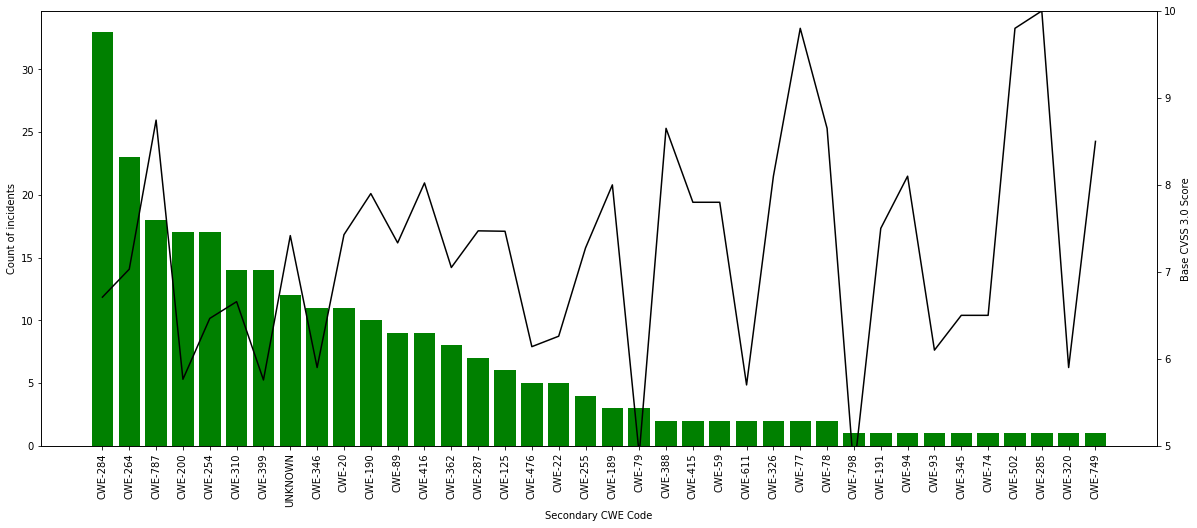

In [57]:
fig, ax1 = plt.subplots(figsize = (20,8))

ax2 = ax1.twinx()
ax1.bar(CWE_2_summary.drop("NONE").index, CWE_2_summary.drop("NONE")["Count"], color ='green')
ax2.plot(CWE_2_summary.drop("NONE").index, CWE_2_summary.drop("NONE")["CVSS 3.0 Score"], color = 'black')

# I have dropped all CWE codes of "NONE" above, as this represents the vast majority of secondary CWE entries

ax1.set_xlabel('Secondary CWE Code')
ax1.set_ylabel('Count of incidents')
ax2.set_ylabel('Base CVSS 3.0 Score')
ax2.set_ylim(bottom = 5, top = 10)
    
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    
plt.show()

In [58]:
# Recording the number of times each CWE code appears
df_incident_counts = ((df_w_CWE_defs_cleaned.groupby("CWE Code 1").count())["CVE ID"]).to_frame()

In [59]:
# Renaming columns for easier analysis
df_incident_counts = df_incident_counts.rename(columns={"CVE ID": "CWE Count"})

In [60]:
# Merging the CWE counts with the original clean data frame
df_w_CWE_defs_counts = df_w_CWE_defs_cleaned.merge(df_incident_counts, how="left", on="CWE Code 1")

In [61]:
# Isolating only those CWE codes for which there were 100 or more events
df_sig_CWE = df_w_CWE_defs_counts[df_w_CWE_defs_counts["CWE Count"]>99]

In [62]:
df_sig_CWE.groupby("CWE Code 1").mean()["impact.baseMetricV3.cvssV3.baseScore"].sort_values(ascending=False)

CWE Code 1
CWE-89     8.621875
CWE-416    8.539355
CWE-119    8.432562
CWE-190    8.161386
CWE-264    7.584395
UNKNOWN    7.362500
CWE-284    7.282637
CWE-20     7.053479
CWE-125    6.741989
CWE-399    6.640110
CWE-476    6.617886
CWE-254    6.608383
CWE-79     5.914085
CWE-200    5.616557
Name: impact.baseMetricV3.cvssV3.baseScore, dtype: float64

In [63]:
CWE_416_info = df_w_CWE_defs_cleaned[df_w_CWE_defs_cleaned["CWE Code 1"]=="CWE-416"][["CWE Code 1", "CWE Code 1 Name", "CWE Code 1 Description"]].iloc[0]
print(CWE_416_info[0])
print(CWE_416_info[1])
print(CWE_416_info[2])

CWE-416
Use After Free
Referencing memory after it has been freed can cause a program to crash, use unexpected values, or execute code.


In [64]:
CWE_89_info = df_w_CWE_defs_cleaned[df_w_CWE_defs_cleaned["CWE Code 1"]=="CWE-89"][["CWE Code 1", "CWE Code 1 Name", "CWE Code 1 Description"]].iloc[0]
print(CWE_89_info[0])
print(CWE_89_info[1])
print(CWE_89_info[2])

CWE-89
SQL Injection
The software constructs all or part of an SQL command using externally-influenced input from an upstream component, but it does not neutralize or incorrectly neutralizes special elements that could modify the intended SQL command when it is sent to a downstream component.


In [65]:
from sklearn.cluster import KMeans

In [66]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [67]:
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

In [68]:
feature_analysis = df_w_CWE_defs_cleaned.drop(["CVE ID","CWE Code 1 Name",
                                               "CWE Code 2 Name",
                                               "CWE Code 1 Description",
                                               "CWE Code 2 Description",
                                               "impact.baseMetricV2.cvssV2.accessComplexity",
                                               "impact.baseMetricV2.cvssV2.accessVector",
                                               "impact.baseMetricV2.cvssV2.authentication",
                                               "impact.baseMetricV2.cvssV2.availabilityImpact",
                                               "impact.baseMetricV2.cvssV2.baseScore",
                                               "impact.baseMetricV2.cvssV2.confidentialityImpact",
                                               "impact.baseMetricV2.cvssV2.integrityImpact",
                                               "impact.baseMetricV2.cvssV2.version",
                                               "impact.baseMetricV2.exploitabilityScore",
                                               "impact.baseMetricV2.impactScore",
                                               "impact.baseMetricV2.obtainAllPrivilege",
                                               "impact.baseMetricV2.obtainOtherPrivilege",
                                               "impact.baseMetricV2.obtainUserPrivilege",
                                               "impact.baseMetricV2.severity",
                                               "impact.baseMetricV2.userInteractionRequired",
                                               "impact.baseMetricV3.cvssV3.version"], axis=1)

In [69]:
feature_analysis = pd.get_dummies(feature_analysis)

In [70]:
feature_analysis = feature_analysis.apply(pd.to_numeric, errors='coerce')
# Ensuring that all the outputs are numeric values

In [71]:
feature_analysis.head()

,impact.baseMetricV3.cvssV3.baseScore,impact.baseMetricV3.exploitabilityScore,impact.baseMetricV3.impactScore,impact.baseMetricV3.cvssV3.attackComplexity_HIGH,impact.baseMetricV3.cvssV3.attackComplexity_LOW,impact.baseMetricV3.cvssV3.attackVector_ADJACENT_NETWORK,impact.baseMetricV3.cvssV3.attackVector_LOCAL,impact.baseMetricV3.cvssV3.attackVector_NETWORK,impact.baseMetricV3.cvssV3.attackVector_PHYSICAL,impact.baseMetricV3.cvssV3.availabilityImpact_HIGH,impact.baseMetricV3.cvssV3.availabilityImpact_LOW,impact.baseMetricV3.cvssV3.availabilityImpact_NONE,impact.baseMetricV3.cvssV3.baseSeverity_CRITICAL,impact.baseMetricV3.cvssV3.baseSeverity_HIGH,impact.baseMetricV3.cvssV3.baseSeverity_LOW,impact.baseMetricV3.cvssV3.baseSeverity_MEDIUM,impact.baseMetricV3.cvssV3.confidentialityImpact_HIGH,impact.baseMetricV3.cvssV3.confidentialityImpact_LOW,impact.baseMetricV3.cvssV3.confidentialityImpact_NONE,impact.baseMetricV3.cvssV3.integrityImpact_HIGH,impact.baseMetricV3.cvssV3.integrityImpact_LOW,impact.baseMetricV3.cvssV3.integrityImpact_NONE,impact.baseMetricV3.cvssV3.privilegesRequired_HIGH,impact.baseMetricV3.cvssV3.privilegesRequired_LOW,impact.baseMetricV3.cvssV3.privilegesRequired_NONE,impact.baseMetricV3.cvssV3.scope_CHANGED,impact.baseMetricV3.cvssV3.scope_UNCHANGED,impact.baseMetricV3.cvssV3.userInteraction_NONE,impact.baseMetricV3.cvssV3.userInteraction_REQUIRED,CWE Code 1_CWE-113,CWE Code 1_CWE-116,CWE Code 1_CWE-118,CWE Code 1_CWE-119,CWE Code 1_CWE-125,CWE Code 1_CWE-129,CWE Code 1_CWE-134,CWE Code 1_CWE-17,CWE Code 1_CWE-172,CWE Code 1_CWE-18,CWE Code 1_CWE-184,CWE Code 1_CWE-189,CWE Code 1_CWE-19,CWE Code 1_CWE-190,CWE Code 1_CWE-191,CWE Code 1_CWE-199,CWE Code 1_CWE-20,CWE Code 1_CWE-200,CWE Code 1_CWE-22,CWE Code 1_CWE-254,CWE Code 1_CWE-255,...,CWE Code 1_CWE-787,CWE Code 1_CWE-79,CWE Code 1_CWE-798,CWE Code 1_CWE-89,CWE Code 1_CWE-90,CWE Code 1_CWE-91,CWE Code 1_CWE-918,CWE Code 1_CWE-93,CWE Code 1_CWE-94,CWE Code 1_CWE-99,CWE Code 1_UNKNOWN,CWE Code 2_CWE-125,CWE Code 2_CWE-189,CWE Code 2_CWE-190,CWE Code 2_CWE-191,CWE Code 2_CWE-20,CWE Code 2_CWE-200,CWE Code 2_CWE-22,CWE Code 2_CWE-254,CWE Code 2_CWE-255,CWE Code 2_CWE-264,CWE Code 2_CWE-284,CWE Code 2_CWE-285,CWE Code 2_CWE-287,CWE Code 2_CWE-310,CWE Code 2_CWE-320,CWE Code 2_CWE-326,CWE Code 2_CWE-345,CWE Code 2_CWE-346,CWE Code 2_CWE-362,CWE Code 2_CWE-388,CWE Code 2_CWE-399,CWE Code 2_CWE-415,CWE Code 2_CWE-416,CWE Code 2_CWE-476,CWE Code 2_CWE-502,CWE Code 2_CWE-59,CWE Code 2_CWE-611,CWE Code 2_CWE-74,CWE Code 2_CWE-749,CWE Code 2_CWE-77,CWE Code 2_CWE-78,CWE Code 2_CWE-787,CWE Code 2_CWE-79,CWE Code 2_CWE-798,CWE Code 2_CWE-89,CWE Code 2_CWE-93,CWE Code 2_CWE-94,CWE Code 2_NONE,CWE Code 2_UNKNOWN
0,7.3,1.3,5.9,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,7.8,1.8,5.9,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,5.5,1.8,3.6,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,5.5,1.8,3.6,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,5.0,1.3,3.6,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [72]:
possible_k_values = range(2, 11, 1)

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, feature_analysis) for k in possible_k_values]

In [73]:
# Display all of the possible k values and associated errors
list(zip(possible_k_values, errors_per_k))

[(2, 0.359648913327272),
 (3, 0.3170495889945327),
 (4, 0.3230140964106512),
 (5, 0.33336775029365473),
 (6, 0.3596282917034757),
 (7, 0.33736215236219336),
 (8, 0.3363294642351515),
 (9, 0.35004542087952917),
 (10, 0.3439926576070416)]

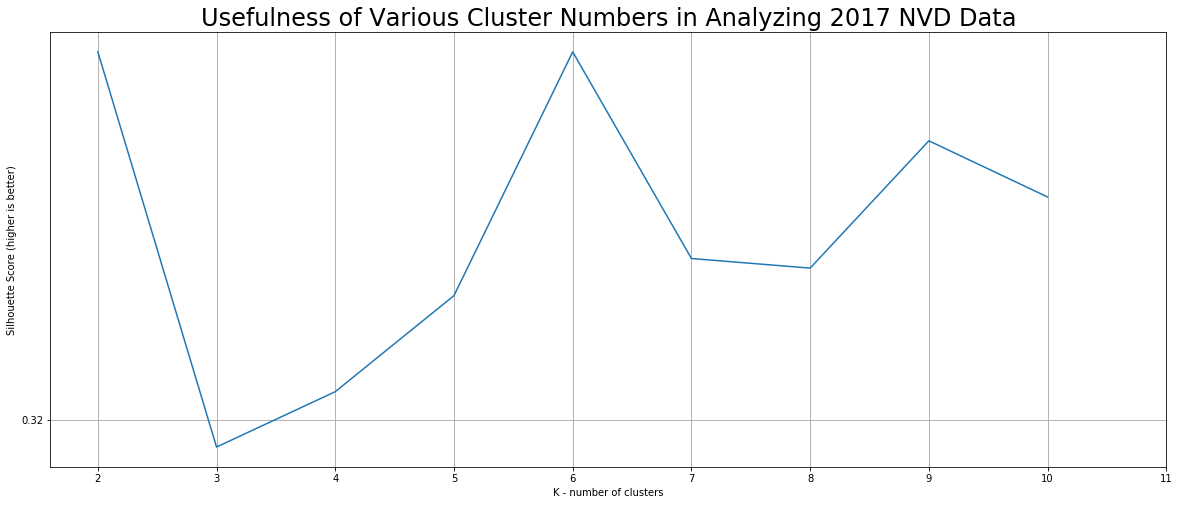

In [74]:
# Plotting the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(20, 8))
ax.set_xlabel('K - number of clusters')
ax.set_ylabel('Silhouette Score (higher is better)')
ax.plot(possible_k_values, errors_per_k)
plt.title("Usefulness of Various Cluster Numbers in Analyzing 2017 NVD Data", fontsize = 24)

# Labeling the chart and creating the grid/tick lines
xticks = np.arange(min(possible_k_values), max(possible_k_values)+2, 1)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

In [75]:
# Initializing my model with number of clusters and setting the random state
kmeans_6 = KMeans(n_clusters = 6, random_state = 42)
predictions_clusters = kmeans_6.fit_predict(feature_analysis)

In [76]:
np.unique(predictions_clusters, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32),
 array([1107,  550, 2184,  961,  718, 1443]))

In [77]:
predictions_clusters

array([2, 2, 5, ..., 4, 4, 4], dtype=int32)

In [78]:
predictions_clusters = predictions_clusters + 1
# Adding one to the cluster numbers so there is no "zero-th" cluster

In [79]:
# Turning the predictions into a data frame for later use
df_predicted_clusters = pd.DataFrame(predictions_clusters)
df_predicted_clusters = df_predicted_clusters.rename(columns={0: "Cluster"})

In [80]:
df_predicted_clusters["Cluster"].value_counts().sort_index()

1    1107
2     550
3    2184
4     961
5     718
6    1443
Name: Cluster, dtype: int64

In [81]:
df_CWE_clusters = df_w_CWE_defs_cleaned.join(pd.DataFrame(df_predicted_clusters))

In [82]:
df_CWE_base_CVSS = df_CWE_clusters.groupby("Cluster").mean()["impact.baseMetricV3.cvssV3.baseScore"].sort_values(ascending=False)

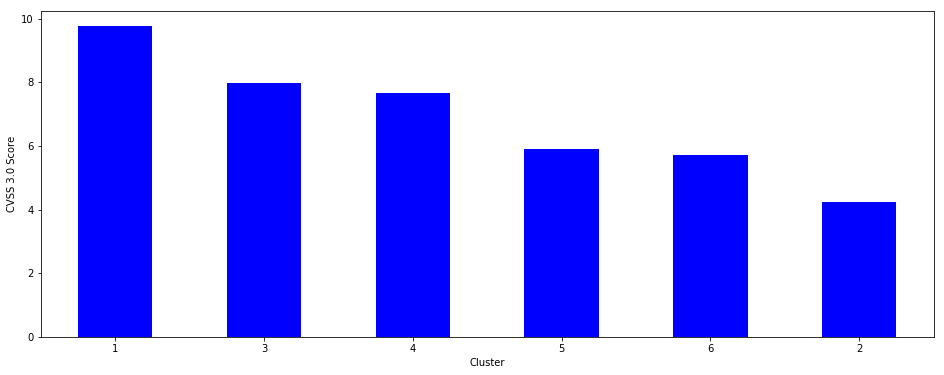

In [83]:
fig = df_CWE_base_CVSS.plot(kind="bar", figsize = (16,6), color = "b")
fig.set_ylabel('CVSS 3.0 Score');

for tick in fig.get_xticklabels():
    tick.set_rotation(0)

In [84]:
colors_clusters = list(np.sort(df_CWE_clusters['Cluster'].unique()))
# Creating a variable 'colors' and putting it into numerical order to facilitate the plotting below
colors_clusters

[1, 2, 3, 4, 5, 6]

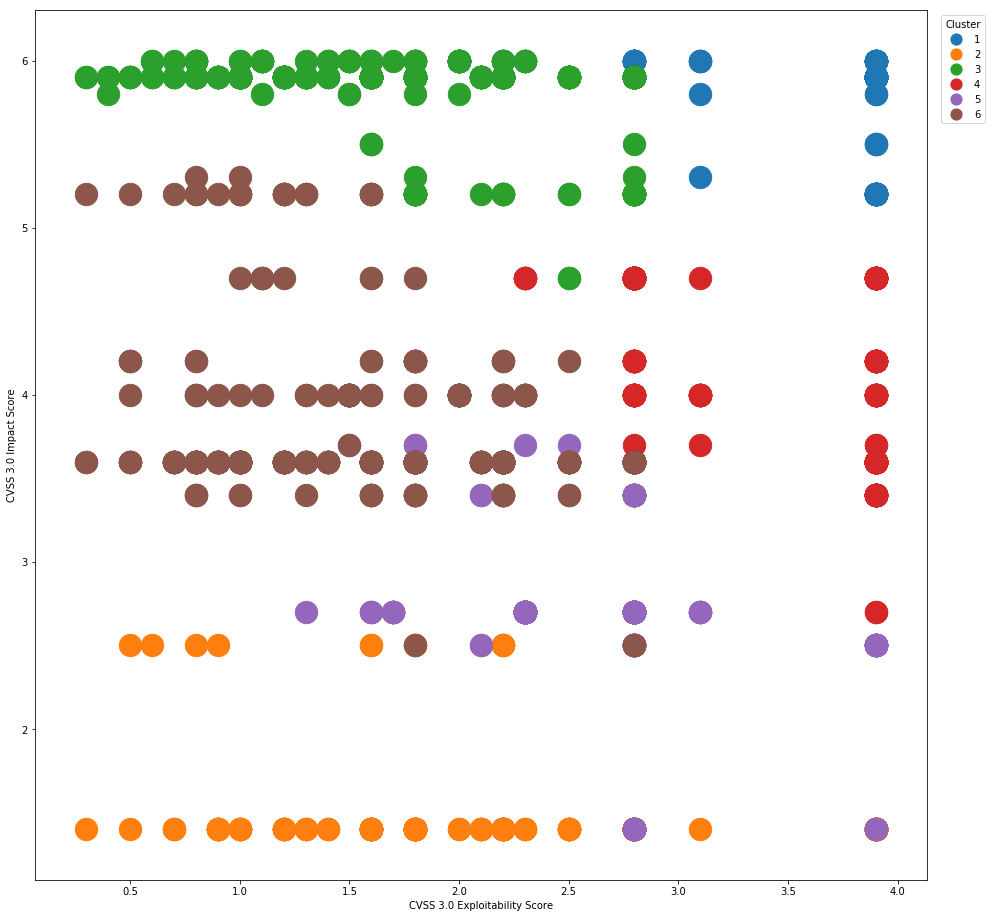

In [85]:
plt.figure(figsize=(16, 16))
plt.xlabel('CVSS 3.0 Exploitability Score')
plt.ylabel('CVSS 3.0 Impact Score')
colors_clusters = list(np.sort(df_CWE_clusters['Cluster'].unique()))
for i in range(len(colors_clusters)):
    data = df_CWE_clusters.loc[df_CWE_clusters["Cluster"] == colors_clusters[i]]
    plt.scatter("impact.baseMetricV3.exploitabilityScore", "impact.baseMetricV3.impactScore", s = 500, data = data, label = colors_clusters[i])

leg = plt.legend(markerscale = 0.5, title = "Cluster", loc='upper right', bbox_to_anchor=(1.07, 1))

for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
plt.show()

In [86]:
def rand_jitter(arr):
    stdev = .02*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

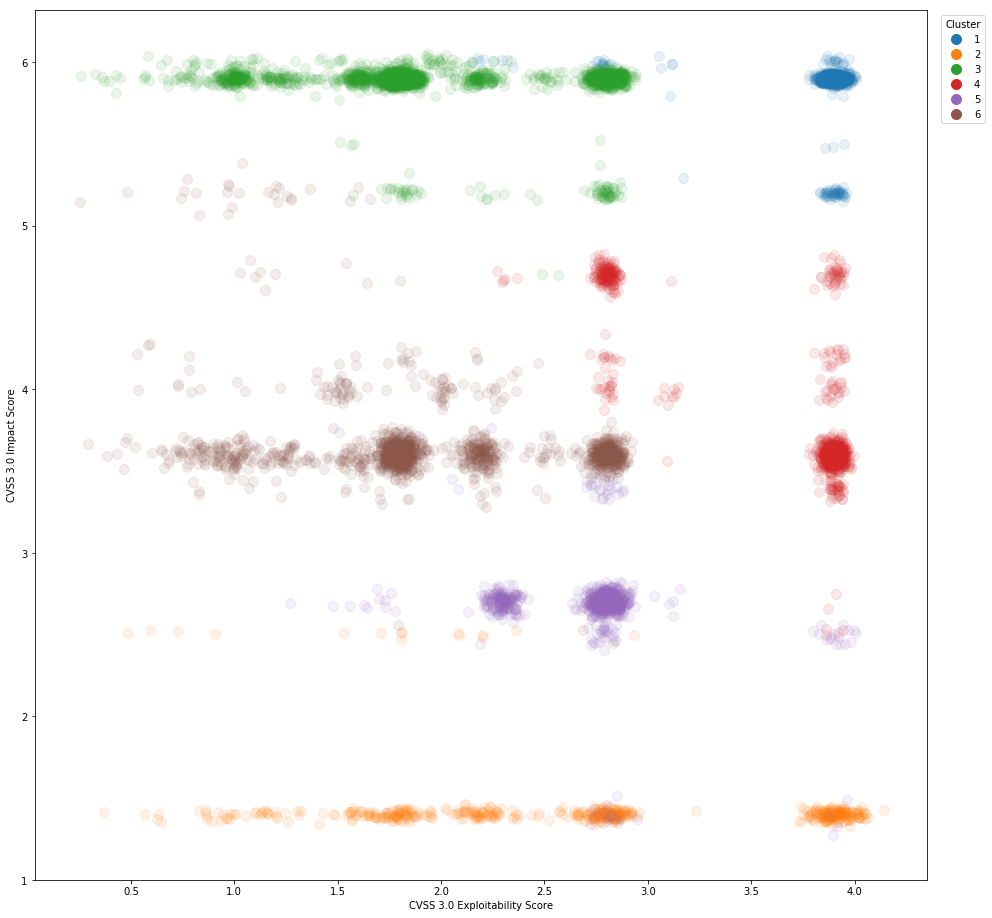

In [87]:
plt.figure(figsize=(16, 16))
plt.xlabel('CVSS 3.0 Exploitability Score')
plt.ylabel('CVSS 3.0 Impact Score')
colors_clusters = list(np.sort(df_CWE_clusters['Cluster'].unique()))
for i in range(len(colors_clusters)):
    data = df_CWE_clusters.loc[df_CWE_clusters["Cluster"] == colors_clusters[i]]
    # Adding random jitter
    data["impact.baseMetricV3.exploitabilityScore"] = rand_jitter(data["impact.baseMetricV3.exploitabilityScore"])
    data["impact.baseMetricV3.impactScore"] = rand_jitter(data["impact.baseMetricV3.impactScore"])
    # Plotting the jittered points.
    plt.scatter("impact.baseMetricV3.exploitabilityScore", "impact.baseMetricV3.impactScore", s = 100, alpha = 0.1, cmap = "set1", data=data, label=colors_clusters[i])

leg = plt.legend(markerscale = 1, title = "Cluster", loc='upper right', bbox_to_anchor=(1.07, 1))

for lh in leg.legendHandles:
    lh.set_alpha(1)
    
plt.show()

In [88]:
CVE_Equifax = df_w_CWE_defs_cleaned[df_w_CWE_defs_cleaned["CVE ID"]=="CVE-2017-5638"]
CVE_Equifax

,CVE ID,impact.baseMetricV2.cvssV2.accessComplexity,impact.baseMetricV2.cvssV2.accessVector,impact.baseMetricV2.cvssV2.authentication,impact.baseMetricV2.cvssV2.availabilityImpact,impact.baseMetricV2.cvssV2.baseScore,impact.baseMetricV2.cvssV2.confidentialityImpact,impact.baseMetricV2.cvssV2.integrityImpact,impact.baseMetricV2.cvssV2.version,impact.baseMetricV2.exploitabilityScore,impact.baseMetricV2.impactScore,impact.baseMetricV2.obtainAllPrivilege,impact.baseMetricV2.obtainOtherPrivilege,impact.baseMetricV2.obtainUserPrivilege,impact.baseMetricV2.severity,impact.baseMetricV2.userInteractionRequired,impact.baseMetricV3.cvssV3.attackComplexity,impact.baseMetricV3.cvssV3.attackVector,impact.baseMetricV3.cvssV3.availabilityImpact,impact.baseMetricV3.cvssV3.baseScore,impact.baseMetricV3.cvssV3.baseSeverity,impact.baseMetricV3.cvssV3.confidentialityImpact,impact.baseMetricV3.cvssV3.integrityImpact,impact.baseMetricV3.cvssV3.privilegesRequired,impact.baseMetricV3.cvssV3.scope,impact.baseMetricV3.cvssV3.userInteraction,impact.baseMetricV3.cvssV3.version,impact.baseMetricV3.exploitabilityScore,impact.baseMetricV3.impactScore,CWE Code 1,CWE Code 2,CWE Code 1 Name,CWE Code 1 Description,CWE Code 2 Name,CWE Code 2 Description
6692,CVE-2017-5638,LOW,NETWORK,NONE,COMPLETE,10.0,COMPLETE,COMPLETE,2.0,10.0,10.0,False,False,False,HIGH,False,LOW,NETWORK,HIGH,10.0,CRITICAL,HIGH,HIGH,NONE,CHANGED,NONE,3.0,3.9,6.0,CWE-20,NONE,Input Validation,The product does not validate or incorrectly v...,NaN,NaN


In [89]:
CWE_Equifax = df_w_CWE_defs_cleaned[df_w_CWE_defs_cleaned["CWE Code 1"]=="CWE-20"][["CWE Code 1", "CWE Code 1 Name", "CWE Code 1 Description"]].iloc[0]
print(CWE_Equifax[0])
print(CWE_Equifax[1])
print(CWE_Equifax[2])

CWE-20
Input Validation
The product does not validate or incorrectly validates input that can affect the control flow or data flow of a program.


In [90]:
df_CWE_clusters[df_CWE_clusters["CVE ID"]=="CVE-2017-5638"]["Cluster"]

6692    1
Name: Cluster, dtype: int32

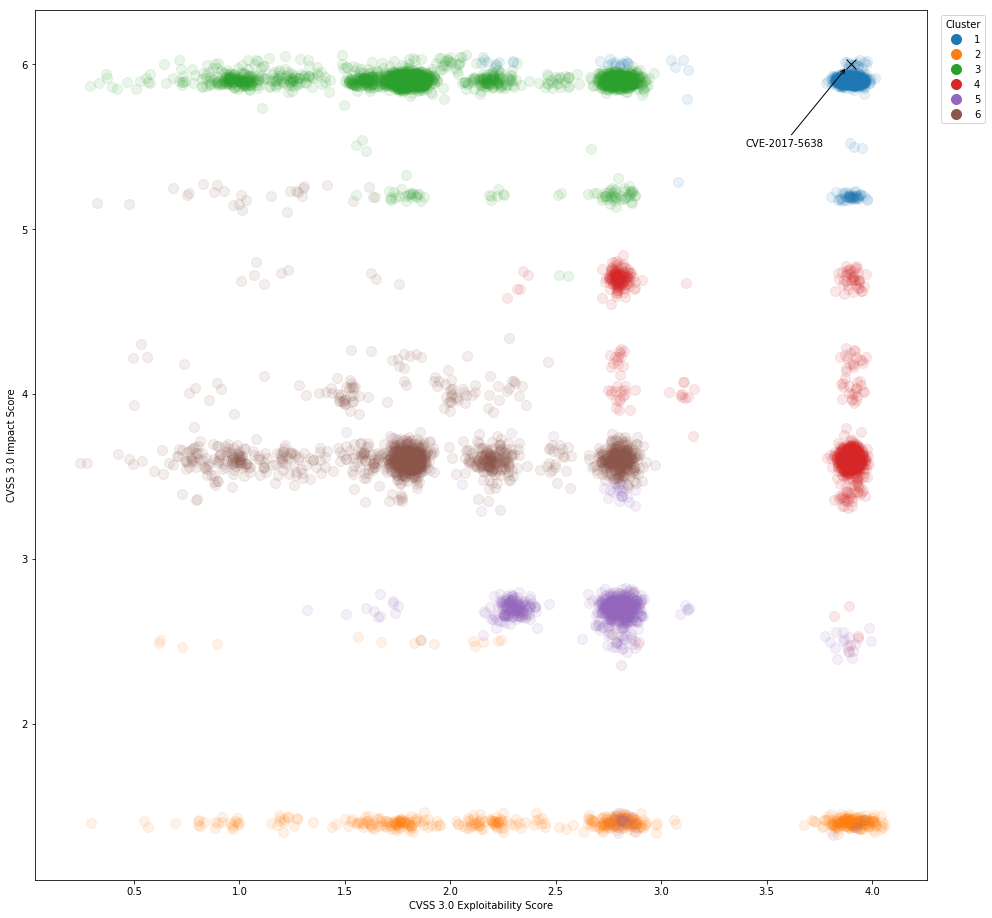

In [91]:
plt.figure(figsize=(16, 16))

plt.xlabel('CVSS 3.0 Exploitability Score')
plt.ylabel('CVSS 3.0 Impact Score')

cluster_colors = list(np.sort(df_CWE_clusters['Cluster'].unique()))

for i in range(len(colors_clusters)):
    data = df_CWE_clusters.loc[df_CWE_clusters["Cluster"] == colors_clusters[i]]
    # Adding random jitter
    data["impact.baseMetricV3.exploitabilityScore"] = rand_jitter(data["impact.baseMetricV3.exploitabilityScore"])
    data["impact.baseMetricV3.impactScore"] = rand_jitter(data["impact.baseMetricV3.impactScore"])
    # Plotting the jittered points.
    plt.scatter("impact.baseMetricV3.exploitabilityScore", "impact.baseMetricV3.impactScore", s = 100, alpha = 0.1, cmap = "tab30", data=data, label=colors_clusters[i])

leg = plt.legend(markerscale = 1, title = "Cluster", loc='upper right', bbox_to_anchor=(1.07, 1))

for lh in leg.legendHandles: 
    lh.set_alpha(1)

#Plotting the Equifax vulnerability on the graphic
Equifax_X = CVE_Equifax["impact.baseMetricV3.exploitabilityScore"]
Equifax_Y = CVE_Equifax["impact.baseMetricV3.impactScore"]

plt.plot(Equifax_X, Equifax_Y, marker='x', markersize=10, color="black")
plt.annotate("CVE-2017-5638", color = "black", xy=(Equifax_X-.02, Equifax_Y-.02), xytext=(Equifax_X-.5, Equifax_Y-.5), arrowprops=dict(edgecolor="black", arrowstyle="->"))

plt.show();